<a href="https://colab.research.google.com/github/WakyeBoy/Intro-to-machine-learning/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Multiple Linear & Logistic Regression, and PyTorch


## Version history

| Date | Author | Description |
|:----:|:------:|:------------|
2021-02-08 | Josiah Wang | First version |
2021-11-08 | Josiah Wang | Fixed docstring for forward() - should return a np.ndarray. Also fixed some formatting of equations in text for multiple linear regression |
2021-11-13 | Josiah Wang | In Multiple linear regression > Gradients, $x_1$ should be $x_1^{(i)}$  |
2022-10-28 | Josiah Wang | Added a few more resources for learning PyTorch |
2022-11-15 | Josiah Wang | Updated to `ax = fig.add_subplot(projection='3d')`. The original `fig.gca(projection='3d')` is deprecated.
2022-11-15 | Josiah Wang | Fixed errors for PyTorch section when running on GPU.
2023-11-16 | Josiah Wang | Updated link to the latest version of Python Programming's Deep Learning tuotrial.

## Introduction

This lab exercise is divided into three parts.

In the first part, you will extend your simple linear regression model from the previous lab to implement a **multiple linear regression** model which can handle more than one input variable. You will also start implementing *vectorised code* to enable your algorithm to perform computations on multiple training instances simultaneously, rather than on one instance at a time.

In the second part, you will tweak your linear regression model to become a **logistic regression** classifier to tackle a classification problem. This really only require several tweaks.

The final part will consist of a simple introduction to PyTorch, where you will get some idea about how to put together a linear regressor in PyTorch. This will help you figure out how to bring the idea further for implementing Neural Networks.

By the end of this lab exercise, you will have
- implemented and trained a multiple regression model
- implemented vectorised code enabling you to peform batching
- implemented and trained a logistic regression model
- experimented with using PyTorch for linear regression

## Multiple linear regression

In the previous lab exercise, you have implemented a simple linear regression with one input variable and one output variable from scratch.

You will often need to use more than one input variable. So let us try to make the linear regression model a bit more general to accomodate more input variables.

You will also try to make our computations more efficient by vectorising them to handle multiple data points in one go, rather than individually as you did in the previous lab.  

As with the previous exercise, we will develop our model with a toy dataset to ensure that everything is working correctly before using it on a real dataset.

In the code below, we generate an artificial dataset with 2 input variables $x_1$ and $x_2$. The dataset is generated from $y=4x_1+2.5x_2+1.5$, so we expect the algorithm to ideally end up with these parameter values once trained. Since the data is two-dimensional, the model is now a *plane* rather than a line. We also add some noise to the output to make life slightly harder for your algorithm.

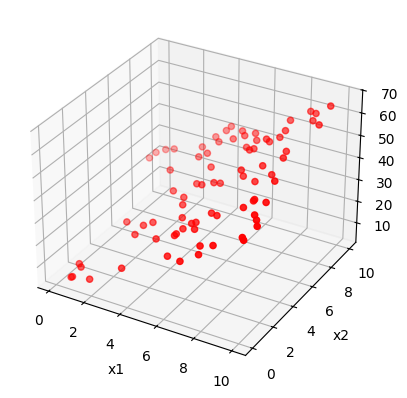

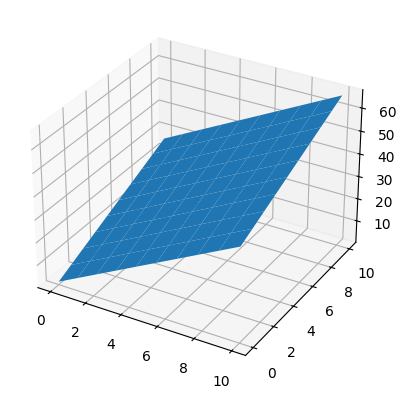

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Generate a toy dataset
# There is no need to understand the details,
# but I'm generating a random dataset from 4*x_1 + 2.5*x_2 + 1.5
# and adding some noise to the output

seed = 60012
rg = default_rng(seed)
weights = np.array([4, 2.5, 1.5])
n_samples = 100
x = rg.random((n_samples, 2))*10.0
x = np.hstack((x, np.ones((n_samples, 1))))
y = np.matmul(x, weights)

# add noise to y
# comment these out if you want to work with a perfectly clean dataset
noise = rg.standard_normal(y.shape)
y = y + noise

x_train = x[:80, :2]
y_train = y[:80]
x_test = x[80:, :2]
y_test = y[80:]

# Plot the training set
fig = plt.figure()
ax = fig.add_subplot(projection='3d') # enable 3D
ax.scatter(x_train[:,0], x_train[:,1], y_train, c="red")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel('y')

# Plot the plane - you are aiming for your algorithm to recover this plane
fig = plt.figure()
ax = fig.add_subplot(projection='3d') # enable 3D
x_plane = np.linspace(0,10,10)
y_plane = np.linspace(0,10,10)
x_plane, y_plane = np.meshgrid(x_plane, y_plane)
z = weights[0] * x_plane + weights[1] * y_plane + weights[2]
surf = ax.plot_surface(x_plane, y_plane, z)

plt.show()



### Model

Now, we will try to implement a Multiple Linear Regression model that can take more than one input:

$$y^{(i)} = w_1 x^{(i)}_1 + w_2 x^{(i)}_2 + w_3 x^{(i)}_3 + \dotsc + b$$

The equation can be made more compact:

$$y^{(i)} = \sum_{k=1}^{K} w_k x^{(i)}_k + b$$

where $K$ is the number of features (dimensions/input).

To make it even more compact, we can use the "bias trick" to combine $b$ with the weights into a single set to save us from having to keep track of the weights and bias parameters separately:

$$y^{(i)} = \sum_{k=1}^{K+1} w_k x^{(i)}_k$$

where $w_{K+1}=b$ and $x_{K+1}^{(i)}=1.0$

We can also represent this equation in vector notation to make computation more efficient.

$$y^{(i)} = W^Tx^{(i)}$$

where

$$
W =
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
b
\end{bmatrix}
$$

$$
x^{(i)} =
\begin{bmatrix}
x_1^{(i)}\\
x_2^{(i)}\\
\vdots\\
1.0\\
\end{bmatrix}
$$

and $W^T$ transposes $W$ to be a row vector.

Note that the input $x^{(i)}$ includes a constant $1$ to account for the bias term.

Going further, we can further improve our representation to allow us to perform computations for multiple data points in one go using matrix multiplication:

$$y = XW$$

where

$$y =
\begin{bmatrix}
y^{(1)}\\
y^{(2)}\\
\vdots\\
y^{(N)}\\
\end{bmatrix}$$

$$X =
\begin{bmatrix}
x_1^{(1)} & x_2^{(1)} & \dotsb & 1.0\\
x_1^{(2)} & x_2^{(2)} & \dotsb & 1.0\\
\vdots & \vdots & \vdots & \vdots\\
x_1^{(N)} & x_2^{(N)} & \dotsb & 1.0\\
\end{bmatrix}$$

$$W =
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
b
\end{bmatrix}
$$

For convenience, we are now using $y = XW$, otherwise we will have to keep transposing both matrices, i.e. $y = W^TX^T$.

Complete the `forward()` method of `MultipleLinearRegression` below. It should really just be a direct translation of the equation $y = XW$.


In [2]:
class MultipleLinearRegression:
    def __init__(self, n_input_vars, random_generator=default_rng()):
        """ Constructor

        Args:
            n_input_vars (int): Number of features (including bias)
            random_generator (RandomGenerator): A random generator
        """

        # we include the bias as an additional weight here
        self.w = random_generator.standard_normal(n_input_vars)
        self.w[-1] = 0. # set the bias to 0

    def forward(self, x):
        """ Perform forward pass given an input x

        Args:
            x (np.ndarray): shape (N, K) where
                            - N is the number of instances,
                            - K is the number of features (including bias)

        Returns:
            np.ndarray: the output of the model given the current weights
        """

        ## TODO: Complete this
        return np.matmul(x, self.w)

    def loss(self, x, y):
        """ Placeholder for later"""
        pass

    def gradient(self, x, y):
        """ Placeholder for later"""
        pass


## Quick test: This should return [17, 15.5]
model = MultipleLinearRegression(3)
model.w = np.array([4, 2.5, 1.5])
x = np.array([[2, 3, 1], [1, 4, 1]])
y_hat = model.forward(x)
print(y_hat) # should print [17, 15.5]

[17.  15.5]


### Loss function

The loss is still the same as what we had in the previous lab. This time, you should return a vector for each of the losses given as input.

$$L = \frac{1}{2} \sum_{i=1}^{N} \left(\hat{y}^{(i)} - y^{(i)}\right)^2 = \frac{1}{2} \sum_{i=1}^{N} \ell^{(i)} $$

$$\ell =  
\begin{bmatrix}
\ell^{(1)}\\
\ell^{(2)}\\
\vdots\\
\ell^{(N)}\\
\end{bmatrix}
=
\begin{bmatrix}
\left(\hat{y}^{(1)} - y^{(1)}\right)^2\\
\left(\hat{y}^{(2)} - y^{(2)}\right)^2\\
\vdots\\
\left(\hat{y}^{(N)} - y^{(N)}\right)^2\\
\end{bmatrix}
$$

Complete the `loss()` method for `MultipleLinearRegresion` below. **Tip**: you should not need to change anything from the previous lab!


In [3]:
# Loss method for MultipleLinearRegression
def loss(self, x, y):
    """ Compute the loss for an input x

    Args:
        x (np.ndarray): shape (N, K) where
                        - N is the number of instances,
                        - K is the number of features (including bias)
        y (np.ndarray): shape (N, ), the ground truth output labels for
                        each of the instance in x

    Returns:
        np.ndarray: shape (N,), the output of the model given the current weights
                    for each instance in x
    """

    # TODO: Complete this (it's the same as in the previous lab)
    return (self.forward(x) - y) ** 2


# A quick hack to bind this function as the MultipleLinearRegression.loss() method
MultipleLinearRegression.loss = loss


## Quick test: This should return [1, 2.25]
model = MultipleLinearRegression(3)
model.w = np.array([4, 2.5, 1.5])
x = np.array([[2, 3, 1], [1, 4, 1]])
y = np.array([18, 14])
test_loss = model.loss(x, y)
print(test_loss) # should print [1, 2.25]

[1.   2.25]


### Gradients

Similarly, for each instance, you will need to return the gradients wrt each parameter.

For your convenience, the gradients are follows:

$\frac{\partial L^{(i)}}{\partial w_1} = \left(\hat{y}^{(i)} - y^{(i)}\right)x_1^{(i)}$

$\frac{\partial L^{(i)}}{\partial w_2} = \left(\hat{y}^{(i)} - y^{(i)}\right)x_2^{(i)}$

$\dotsc$

$\frac{\partial L^{(i)}}{\partial b} = \left(\hat{y}^{(i)} - y^{(i)}\right)$

You should return

$$
\begin{bmatrix}
\frac{\partial L^{(1)}}{\partial W}\\
\frac{\partial L^{(2)}}{\partial W}\\
\vdots\\
\frac{\partial L^{(N)}}{\partial W}
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial L^{(1)}}{\partial w_1} & \frac{\partial L^{(1)}}{\partial w_2} & \dotsc & \frac{\partial L^{(1)}}{\partial b}\\
\frac{\partial L^{(2)}}{\partial w_1} & \frac{\partial L^{(2)}}{\partial w_2} & \dotsc & \frac{\partial L^{(2)}}{\partial b}\\
\vdots & \vdots & \vdots & \vdots\\
\frac{\partial L^{(N)}}{\partial w_1} & \frac{\partial L^{(N)}}{\partial w_2} & \dotsc & \frac{\partial L^{(N)}}{\partial b}\\
\end{bmatrix}
$$

Complete the `gradient()` method of `MultipleLinearRegression` below. Tip: take advantage of the repetitive patterns between the derivatives for the different parameters!

In [4]:
def gradient(self, x, y):
    """ Compute partial derivatives wrt w and b

    Args:
        x (np.ndarray): shape (N, K) where
                        - N is the number of instances,
                        - K is the number of features (including bias)
        y (np.ndarray): shape (N, ), the ground truth output labels for
                        each of the instance in x

    Returns:
        np.ndarray: shape (N, K) containing the partial derivatives
                        wrt the K weights, for each N instance
    """
    ## TODO: Complete this
    error = self.forward(x) - y
    return error.reshape(-1, 1) * x


# A quick hack to bind this function as the SimpleLinearRegression.gradient() method
MultipleLinearRegression.gradient = gradient


## Quick test
model = MultipleLinearRegression(3)
model.w = np.array([4, 2.5, 1.5])
x = np.array([[2, 3, 1], [1, 4, 1]])
y = np.array([18, 14])
grad = model.gradient(x, y)
print(grad)
# should print
#[[-2.  -3.  -1. ]
# [ 1.5  6.   1.5]]

[[-2.  -3.  -1. ]
 [ 1.5  6.   1.5]]


### Optimisation with gradient descent

Finally, it is time to train your model! We will use vanilla gradient descent as in the last exercise.

Complete the code below. The main change you will need to make compared to last time is that you can now compute the gradients for all training instances in one go, without having to iterate over each individually.

Play around with the learning rate and the number of epochs. You will definitely need to adjust the learning rate! You should be able to approximately recover the parameters of our toy dataset ($w_1=4, w_2=2.5, b=1.5$). You can also try generating a clean version of the dataset (without the added noise) and you will observe a much lower loss.

Once you are done, feel free to try implementing stohastic or mini-batched gradient descent if you feel like it (completely optional)!


In [5]:
n_input = 2
model = MultipleLinearRegression(n_input+1, rg)

learning_rate = 0.000025
n_epochs = 100000

# concat the constant 1 to each instance for the bias
x_train_ext = np.hstack((x_train, np.ones((x_train.shape[0], 1))))

for epoch in range(n_epochs):
    # TODO: compute the overall loss for x_train_ext
    error = np.sum(model.loss(x_train_ext, y_train), axis=0) / x_train_ext.shape[0]


    # TODO: compute the sum of the gradients across instances wrt to each parameter
    grad = np.sum(model.gradient(x_train_ext, y_train), axis=0)

    model.w = model.w - learning_rate * grad
    print(f"Epoch: {epoch}\t w: {model.w}\t L: {error:.4f}")


Streaming output truncated to the last 5000 lines.
Epoch: 95000	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95001	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95002	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95003	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95004	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95005	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95006	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95007	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95008	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95009	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95010	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95011	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95012	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95013	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoch: 95014	 w: [4.0005648  2.54283217 1.29440663]	 L: 1.2739
Epoc

### Prediction and evaluation

For completeness, let us just make some predictions on the test set, and compute the MSE on the test set.

In [6]:
def mse(y_gold, y_prediction):
    assert len(y_gold) == len(y_prediction)
    return np.square(y_gold - y_prediction).mean()


# concat the constant 1 to each test instance for the bias
x_test_ext = np.hstack((x_test, np.ones((x_test.shape[0], 1))))

# predict the output for x_test_ext
y_predictions = model.forward(x_test_ext)

print(f"Gold, Prediction")
for (gold, prediction) in zip(y_test, y_predictions):
    print(f"{gold:.4f}, {prediction:.4f}")

print("MSE: ", mse(y_test, y_predictions))

Gold, Prediction
33.9724, 35.1517
22.5558, 22.6155
39.9328, 40.2904
29.5725, 29.5048
42.6419, 43.8152
48.9940, 49.4200
47.9574, 50.0293
32.8934, 33.9628
12.8563, 13.1390
20.7982, 22.6347
11.3521, 11.2279
31.1925, 30.0457
43.3333, 44.4072
44.4856, 45.8552
39.6313, 38.8736
34.8354, 35.0659
21.4195, 20.5770
44.7296, 44.6157
47.3141, 45.8265
27.7459, 28.6692
MSE:  1.037436479333091


## Logistic regression

The linear regression model can be easily extended to perform classification. In this section, you will now turn the linear regression model from earlier into a **logistic regression** model that can be used to perform **binary classification**.

We will go back to our good old Iris dataset for this section. To enable us to perform *binary* classification, we will only keep the first 100 instances (which make up the first two classes).


In [7]:
import os

# Download iris data if it does not exist
if not os.path.exists("iris.data"):
    !wget -O iris.data https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

def read_dataset(filepath):
    """ Read in the dataset from the specified filepath

    Args:
        filepath (str): The filepath to the dataset file

    Returns:
        tuple: returns a tuple of (x, y, classes), each being a numpy array.
               - x is a numpy array with shape (N, K),
                   where N is the number of instances
                   K is the number of features/attributes
               - y is a numpy array with shape (N, ), and each element should be
                   an integer from 0 to C-1 where C is the number of classes
               - classes : a numpy array with shape (C, ), which contains the
                   unique class labels corresponding to the integers in y
    """

    x = []
    y_labels = []
    for line in open(filepath):
        if line.strip() != "": # handle empty rows in file
            row = line.strip().split(",")
            x.append(list(map(float, row[:-1])))
            y_labels.append(row[-1])

    x = x[:100]
    y_labels = y_labels[:100]

    [classes, y] = np.unique(y_labels, return_inverse=True)

    x = np.array(x)
    y = np.array(y)
    return (x, y, classes)


def split_dataset(x, y, test_proportion, random_generator=default_rng()):
    """ Split dataset into training and test sets, according to the given
        test set proportion.

    Args:
        x (np.ndarray): Instances, numpy array with shape (N,K)
        y (np.ndarray): Output label, numpy array with shape (N,)
        test_proprotion (float): the desired proportion of test examples
                                 (0.0-1.0)
        random_generator (np.random.Generator): A random generator

    Returns:
        tuple: returns a tuple of (x_train, x_test, y_train, y_test)
               - x_train (np.ndarray): Training instances shape (N_train, K)
               - x_test (np.ndarray): Test instances shape (N_test, K)
               - y_train (np.ndarray): Training labels, shape (N_train, )
               - y_test (np.ndarray): Test labels, shape (N_test, )
    """

    shuffled_indices = random_generator.permutation(len(x))
    n_test = round(len(x) * test_proportion)
    n_train = len(x) - n_test
    x_train = x[shuffled_indices[:n_train]]
    y_train = y[shuffled_indices[:n_train]]
    x_test = x[shuffled_indices[n_train:]]
    y_test = y[shuffled_indices[n_train:]]
    return (x_train, x_test, y_train, y_test)


(x, y, classes) = read_dataset("iris.data")
print(x.shape)  # (100, 4)
print(y.shape)  # (100,)
print(classes)  # ['Iris-setosa' 'Iris-versicolor']

x_train, x_test, y_train, y_test = split_dataset(x, y,
                                                 test_proportion=0.2,
                                                 random_generator=rg)
print(x_train.shape)
print(x_test.shape)


--2025-11-16 14:12:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.data’

iris.data               [ <=>                ]   4.44K  --.-KB/s    in 0s      

2025-11-16 14:12:41 (76.0 MB/s) - ‘iris.data’ saved [4551]

(100, 4)
(100,)
['Iris-setosa' 'Iris-versicolor']
(80, 4)
(20, 4)


We will also perform standardisation on the dataset to ensure that the features are in a similar range. This is important because the range of the features is quite different, and this will affect parameter optimisation using gradient descent.

In [8]:
# perform standardisation on the dataset
mu = x_train.mean(axis=0)
sigma = x_train.std(axis=0)

x_train = (x_train - mu) / sigma
x_test = (x_test - mu) / sigma

### Model

You will now adapt the linear regression model from earlier and turn it into a logistic regression classifier.

The Logistic Regression classifier should return:

$$y = \sigma(XW)$$

where

$$ \sigma(x) = \frac{1}{1 + exp^{-x}}$$

Firstly, you need to modify the `forward()` method. This is really just a tiny modification from the linear regression model from earlier. For your convenience, I have included a `sigmoid()` function for your use.

In [9]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


class LogisticRegression:
    def __init__(self, n_input_vars, random_generator=default_rng()):
        """ Constructor

        Args:
            n_input_vars (int): Number of features (including bias)
            random_generator (RandomGenerator): A random generator
        """

        # we include the bias as an additional weight here
        self.w = random_generator.standard_normal(n_input_vars)
        self.w[-1] = 0. # set the bias to 0

    def forward(self, x):
        """ Perform forward pass given an input x

        Args:
            x (np.ndarray): shape (N, K) where
                            - N is the number of instances,
                            - K is the number of features (including bias)

        Returns:
            np.npdarray: the output of the model given the current weights
        """
        ## TODO: Complete this
        affine_layer = np.matmul(x, self.w)
        return sigmoid(affine_layer)

    def loss(self, x, y):
        """ Placeholder for later"""
        pass

    def gradient(self, x, y):
        """ Placeholder for later"""
        pass


## Quick test
model = LogisticRegression(3)
model.w = np.array([2, 1, 0.5])
x = np.array([[0.3, 0.5, 0.4], [-0.6, -0.6, -0.5]])
y_hat = model.forward(x)
print(y_hat) # should print [0.78583498 0.11405238]


[0.78583498 0.11405238]


### Loss function

Logistic regression uses a different loss function (binary cross-entropy), so this needs to be modified.

$$L = -\sum_{i=1}^N (y^{(i)}log(\hat{y}^{(i)}) + (1 - y^{(i)})log(1 - \hat{y}^{(i)}))$$

Also, rather than returning the loss for each individual instance, this time we will modify `loss()` so that it returns the overall loss, i.e. $L$ in the equation above. So, `loss()` should return a single float. This is more for our own convenience, since we only need the overall loss anyway.

We will use the `np.log()` (natural logarithm) for this exercise, although it is actually more common to use $log_2$. It is fine to use either as long as you are consistent.

In [10]:
def loss(self, x, y):
    """ Compute the loss for an input x

    Args:
        x (np.ndarray): shape (N, K) where
                        - N is the number of instances,
                        - K is the number of features (including bias)
        y (np.ndarray): shape (N, ), the ground truth output labels for
                        each of the instance in x

    Returns:
        float: the overall loss
    """
    ### TODO: Complete this
    y_hat = self.forward(x)
    inner_sum = np.matmul(y.T, np.log(y_hat)) + np.matmul((1 - y).T, np.log(1 - y_hat))
    return -np.sum(inner_sum, axis=0)


# A quick hack to bind this function as the LogisticRegression.loss() method
LogisticRegression.loss = loss


## Quick test
model = LogisticRegression(3)
model.w = np.array([2, 1, 0.5])
x = np.array([[0.3, 0.5, 0.4], [-0.6, -0.6, -0.5]])
y = np.array([1, 0])
test_loss = model.loss(x, y)
print(test_loss) # should print 0.3621 if you are using np.log (natural logarithm)

# as a reference, the values for the individual loss are [-0.24100845 -0.12109745]

0.3621059050410539


### Gradients

The gradients remain the same as Linear Regression, so no modification is needed.

We will, however, slightly modify `gradient()` so that we return the *sum* of the partial derivatives across all instances. Therefore, the output should be a vector, where each element is the partial derivative wrt to a weight. This should only be a very minor modification.


In [11]:
def gradient(self, x, y):
    """ Compute partial derivatives wrt w and b

    Args:
        x (np.ndarray): shape (N, K) where
                        - N is the number of instances,
                        - K is the number of features (including bias)
        y (np.ndarray): shape (N, ), the ground truth output labels for
                        each of the instance in x

    Returns:
        np.ndarray: shape (K,) containing the sum of the partial derivatives
                        wrt the K weights
    """
    ## TODO: Complete this
    ## (a small change from the previous solution to sum up the gradients)
    error = (self.forward(x) - y)
    gradient_matrix = error.reshape(-1, 1) * x
    return np.sum(gradient_matrix, axis=0)



# A quick hack to bind this function as the SimpleLinearRegression.gradient() method
LogisticRegression.gradient = gradient


## Quick test
model = LogisticRegression(3)
model.w = np.array([2, 1, 0.5])
x = np.array([[0.3, 0.5, 0.4], [-0.6, -0.6, -0.5]])
y = np.array([1, 0])
grad = model.gradient(x, y)
print(grad) # should print [-0.13268093 -0.17551394 -0.1426922 ]

# as a reference, the values of the individual gradients are
# [[-0.06424951 -0.10708251 -0.08566601]
#  [-0.06843143 -0.06843143 -0.05702619]]

[-0.13268093 -0.17551394 -0.1426922 ]


### Optimisation with gradient descent

Gradient descent should not need any major modification.

There is now no need to sum the loss and gradients since we have already done that in `loss()` and `gradients()`.

As usual, play around with the learning rate.



In [12]:
n_input = x_train.shape[1]
model = LogisticRegression(n_input+1, rg)

learning_rate = 0.00025
n_epochs = 10000

# concat the constant 1 to each instance for the bias
x_train_ext = np.hstack((x_train, np.ones((x_train.shape[0], 1))))

for epoch in range(n_epochs):
    error = model.loss(x_train_ext, y_train)
    grad = model.gradient(x_train_ext, y_train)
    model.w = model.w - learning_rate * grad
    print(f"Epoch: {epoch}\t w: {model.w}\t L: {error:.4f}")


Streaming output truncated to the last 5000 lines.
Epoch: 5000	 w: [ 1.83717132 -2.01005914  1.51044327  2.01835321  0.1633581 ]	 L: 0.4902
Epoch: 5001	 w: [ 1.83720946 -2.01011252  1.51053381  2.01844799  0.16337344]	 L: 0.4902
Epoch: 5002	 w: [ 1.83724759 -2.01016589  1.51062433  2.01854276  0.16338878]	 L: 0.4901
Epoch: 5003	 w: [ 1.83728572 -2.01021925  1.51071484  2.01863751  0.16340412]	 L: 0.4900
Epoch: 5004	 w: [ 1.83732383 -2.01027259  1.51080534  2.01873224  0.16341946]	 L: 0.4899
Epoch: 5005	 w: [ 1.83736194 -2.01032593  1.51089581  2.01882696  0.16343479]	 L: 0.4898
Epoch: 5006	 w: [ 1.83740004 -2.01037926  1.51098627  2.01892165  0.16345012]	 L: 0.4897
Epoch: 5007	 w: [ 1.83743814 -2.01043258  1.51107671  2.01901633  0.16346545]	 L: 0.4896
Epoch: 5008	 w: [ 1.83747622 -2.01048589  1.51116713  2.019111    0.16348078]	 L: 0.4896
Epoch: 5009	 w: [ 1.8375143  -2.01053918  1.51125754  2.01920564  0.1634961 ]	 L: 0.4895
Epoch: 5010	 w: [ 1.83755237 -2.01059247  1.51134793  2.019

### Prediction and evaluation

Finally, we will predict the class label on the test set, and use our good old `accuracy` metric for evaluation.

The `forward()` method of `LogisticRegression` still returns floating point values. You will still need to predict a discrete class label (`0` or `1`) for each instance based on this value.

This can easily be done with simple thresholding:
- if $\hat{y} >= 0.5$, classify as class 1
- otherwise classify as class 0

Complete the code below to do this.




In [13]:
def accuracy(y_gold, y_prediction):
    assert len(y_gold) == len(y_prediction)

    try:
        return np.sum(y_gold == y_prediction) / len(y_gold)
    except ZeroDivisionError:
        return 0

# concat the constant 1 to each test instance for the bias
x_test_ext = np.hstack((x_test, np.ones((x_test.shape[0], 1))))

# predict the output for x_test_ext
y_predictions = model.forward(x_test_ext)

### TODO: Convert the float y_predictions to return either 0 or 1
threshold = y_predictions >= 0.5
y_predictions[threshold] = 1
y_predictions[~threshold] = 0

print(f"Gold, Prediction")
for (gold, prediction) in zip(y_test, y_predictions):
    print(f"{gold:.4f}, {prediction:.4f}")

print("Accuracy: ", accuracy(y_test, y_predictions))

Gold, Prediction
0.0000, 0.0000
1.0000, 1.0000
0.0000, 0.0000
0.0000, 0.0000
1.0000, 1.0000
0.0000, 0.0000
1.0000, 1.0000
1.0000, 1.0000
0.0000, 0.0000
0.0000, 0.0000
1.0000, 1.0000
1.0000, 1.0000
1.0000, 1.0000
1.0000, 1.0000
1.0000, 1.0000
0.0000, 0.0000
0.0000, 0.0000
0.0000, 0.0000
0.0000, 0.0000
1.0000, 1.0000
Accuracy:  1.0


## Linear regression with PyTorch

This final section is a practical introduction to using PyTorch, a library which you might find useful for building Neural Networks, and for your second coursework (if you plan to use it).

PyTorch provides you with the `autograd` library, which magically compute gradients for you automatically, removing the need for you to manually work out and implement gradient computations by hand (as we have been doing). This will especially be a bigger hassle when you deal with neural networks.

It also provides you with all the basic "building blocks" to build your neural network layers, as well as loss functions and optimisers (like gradient descent). So, it basically automates everything you have constructed by hand so far (and much more!)

While PyTorch is mainly used for building neural networks, we will introduce it here for linear regression as an example. In reality, it is a bit of an overkill! But you deserve a break since you have worked hard building everything from scratch so far! 😊

I will provide all the codes for this section, so you should just spend time trying to understand how it all works.

Now, run the following code to get our toy dataset from earlier up again.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Generate a toy dataset
# There is no need to understand the details,
# but I'm generating a random dataset from 4*x_1 + 2.5*x_2 + 1.5
# and adding some noise to the output

seed = 60012
rg = default_rng(seed)
weights = np.array([4, 2.5, 1.5])
n_samples = 100
x = rg.random((n_samples, 2))*10.0
x = np.hstack((x, np.ones((n_samples, 1))))
y = np.matmul(x, weights)

# add noise to y
# comment this out if you want to work with a perfectly clean dataset
noise = rg.standard_normal(y.shape)
y = y + noise

x_train = np.array(x[:80, :2])
y_train = y[:80, np.newaxis]
x_test = x[80:, :2]
y_test = y[80:, np.newaxis]


### PyTorch Tensors

A PyTorch `Tensor` is essentially a NumPy array. The additional features are that:
- it allows you to store the value of the gradients from the automatic computation;
- it allows you to use GPUs for computation.

You can construct a new tensor using `torch.tensor()`, passing your list/NumPy array as the first argument. If you already have a NumPy array and do not wish to make a copy, use `torch.from_numpy()`. This way, any changes you make to the tensor will reflect in the original NumPy array.

Let's convert our toy dataset into PyTorch tensors. Run the code below.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Ask PyTorch to store any computed gradients so that we can examine them
x_train_tensor.requires_grad_(True)

# should be "None" at the moment. It will only be filled later after you call backward()
print(x_train_tensor.grad)

# Use a GPU if it exists
# On Google Colab, go to "Edit > Notebook Settings" to allocate a GPU
if torch.cuda.is_available():
    x_train_tensor = x_train_tensor.to('cuda')
    x_test_tensor = x_test_tensor.to('cuda')
    y_train_tensor = y_train_tensor.to('cuda')



None


### Construct a model

You can construct a model by subclassing `torch.nn.Module`. You will need to implement the `forward()` method just like what you did earlier. This time, instead of implementing the equation yourself, you can just plug in PyTorch's `nn.Linear` class.

In [5]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_vars, n_output_vars=1):
        super().__init__() # call constructor of superclass
        self.linear = nn.Linear(n_input_vars, n_output_vars)

    def forward(self, x):
        return self.linear(x)


model = LinearRegression(n_input_vars=2)

if torch.cuda.is_available():
    model.to('cuda')

print("WEIGHT", model.linear.weight)
print("BIAS", model.linear.bias)
print("PARAMS", list(model.parameters()))


WEIGHT Parameter containing:
tensor([[-0.4138,  0.2399]], device='cuda:0', requires_grad=True)
BIAS Parameter containing:
tensor([0.0801], device='cuda:0', requires_grad=True)
PARAMS [Parameter containing:
tensor([[-0.4138,  0.2399]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.0801], device='cuda:0', requires_grad=True)]


### Select loss function

Next is the loss function. Choose what you need from PyTorch's library, all ready to use off the shelf! https://pytorch.org/docs/stable/nn.html#loss-functions

We'll use MSE as the loss this time. If you need sum-of-squared error (like what we have been previously using), supply`reduction="sum"` as an argument.

In [6]:
criterion = torch.nn.MSELoss()
#criterion = torch.nn.MSELoss(reduction="sum") # for SSE

### Select optimiser

Now, choose your favourite optimiser from PyTorch's ready-made optimisers:
https://pytorch.org/docs/stable/optim.html#algorithms

We'll stick to stohastic gradient descent (SGD) for this exercise. For this optimiser, we can set the learning rate with `lr`. Also remember to pass in the parameters that you need optimising.

In [7]:
optimiser = torch.optim.SGD(model.parameters(), lr=0.0001)

### Train the model

Now, we can train our model. The steps inside the training loop is pretty standard. You should be able to understand the steps easily.

In [8]:
n_epochs = 5000

for epoch in range(n_epochs):
    # Reset the gradients
    optimiser.zero_grad()

    # forward pass
    y_hat = model(x_train_tensor)

    # compute loss
    loss = criterion(y_hat, y_train_tensor)

    # Backward pass (compute the gradients)
    loss.backward()

    # update parameters
    optimiser.step()

    print(f"Epoch: {epoch}\t w: {model.linear.weight.data[0]}\t b: {model.linear.bias.data[0]:.4f} \t L: {loss:.4f}")

print(list(model.parameters()))

Streaming output truncated to the last 5000 lines.
Epoch: 3	 w: tensor([-0.2147,  0.4137], device='cuda:0')	 b: 0.1103 	 L: 1546.6174
Epoch: 4	 w: tensor([-0.1665,  0.4556], device='cuda:0')	 b: 0.1176 	 L: 1504.5153
Epoch: 5	 w: tensor([-0.1191,  0.4969], device='cuda:0')	 b: 0.1248 	 L: 1463.5696
Epoch: 6	 w: tensor([-0.0722,  0.5376], device='cuda:0')	 b: 0.1319 	 L: 1423.7484
Epoch: 7	 w: tensor([-0.0260,  0.5777], device='cuda:0')	 b: 0.1389 	 L: 1385.0209
Epoch: 8	 w: tensor([0.0196, 0.6172], device='cuda:0')	 b: 0.1458 	 L: 1347.3572
Epoch: 9	 w: tensor([0.0645, 0.6562], device='cuda:0')	 b: 0.1526 	 L: 1310.7277
Epoch: 10	 w: tensor([0.1089, 0.6946], device='cuda:0')	 b: 0.1593 	 L: 1275.1042
Epoch: 11	 w: tensor([0.1527, 0.7324], device='cuda:0')	 b: 0.1659 	 L: 1240.4590
Epoch: 12	 w: tensor([0.1959, 0.7697], device='cuda:0')	 b: 0.1725 	 L: 1206.7651
Epoch: 13	 w: tensor([0.2385, 0.8065], device='cuda:0')	 b: 0.1789 	 L: 1173.9965
Epoch: 14	 w: tensor([0.2805, 0.8427], devic

### Prediction



In [20]:
def mse(y_gold, y_prediction):
    assert len(y_gold) == len(y_prediction)
    return np.square(y_gold - y_prediction).mean()

y_predictions = model.forward(x_test_tensor)

print(f"Gold, Prediction")
for (gold, prediction) in zip(y_test_tensor, y_predictions):
    print(f"{gold.data[0]}, {prediction.data[0]}")

print("MSE: ", mse(y_test_tensor, y_predictions.detach().cpu().numpy()).data)

Gold, Prediction
33.9724006652832, 35.08972930908203
22.5557918548584, 22.449941635131836
39.93284606933594, 40.273868560791016
29.57248878479004, 29.396154403686523
42.641902923583984, 43.82292938232422
48.994041442871094, 49.483150482177734
47.95741653442383, 50.09572219848633
32.893428802490234, 33.90021896362305
12.856305122375488, 12.89433765411377
20.798208236694336, 22.46926498413086
11.352057456970215, 10.970173835754395
31.192489624023438, 29.93931770324707
43.333316802978516, 44.41957473754883
44.48554992675781, 45.885066986083984
39.63128662109375, 38.84035110473633
34.83544921875, 35.01158142089844
21.419525146484375, 20.39740562438965
44.729583740234375, 44.638221740722656
47.3140869140625, 45.85668182373047
27.745878219604492, 28.54964828491211
MSE:  tensor(1.0378)


/tmp/ipython-input-55241836.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.square(y_gold - y_prediction).mean()


And that is it for our introduction to PyTorch. Essentially, you have implemented the equivalent of a single neuron with an identity activation function. To construct a multi-layered Neural Network, you will have to assemble and nest the "building blocks" provided by PyTorch in a systematic fashion, and choose suitable activation functions. Otherwise, the optimisation process will be similar.

There are many resources if you need further help with PyTorch. The [official PyTorch tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) is useful for a quick tutorial.

The [Deep Learning module](http://wp.doc.ic.ac.uk/bkainz/teaching/70010-deep-learning) also has two nice tutorials (under Week 2), prepared by one of their (and our former) Teaching Assistants Daniel Pace. If you are in a hurry, skip to 26:25 for the first video since most topics before that are NumPy and Tensor basics that you have already used. You only need to know that the tutorial uses underscores after a variable (e.g. `a_`) to indicate that it is a Tensor.

Alternatively, my Teaching Assistant Luca Grillotti has also prepared a [Deep Learning with PyTorch](https://python.pages.doc.ic.ac.uk/lessons/pytorch/) tutorial for my Python Programming module. It goes more deeply into PyTorch. You can skip to Chapter 7 to build an image classifier if you are in a hurry.

## Summary

Congratulations! You have constructed a multiple linear regressor and logistic regression classifier from scratch, and also implemented batching for more efficient computation.

You have also been introduced to PyTorch, by using PyTorch to implement linear regression. Hopefully the hard work you did with implementing the model from scratch in earlier sections paid off, and actually helped you understand and appreciate the power of PyTorch better!

We will leave the task of implementing Neural Networks for your coursework, but hopefully these lab exercises will help start you off in the correct direction!

